## CNN Model

### Imports 

In [95]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Model

In [73]:
# Setting a random seed for reproducibility
np.random.seed(42)

### Reading in image data as X and y

In [74]:
# specify the path with the subfolders of cleaned eye images (each subfolder is an eye condition)
clean_path = './cleaned_eye_images/'

# the target y is the eye condition 
# make a dictionary of eye conditions and integers because y needs to be a number, not a string
condition_dict = {'normal':0, 'retinopathy': 1, 'glaucoma':2, 'cataracts':3}

# make empty lists for X and y
X=[]
y=[]

# iterate through each subfolder (= condition)
for condition in os.listdir(clean_path):
    
    # make sure the subfolder is actually the name of a condition (e.g., not 'DS_Store')
    if condition in condition_dict.keys():
        
        # iterate through each image file in the subfolder
        for file in os.listdir(clean_path+condition):
            
            # added a try/except so that DS_Store files don't trip an error
            try:
                # load the image file
                image = load_img(clean_path+condition+'/'+file)
                
                # convert the image to an array and normalize it by dividing by 255
                image_arr = img_to_array(image) / 255
                
                # add the image array to X
                X.append(image_arr)
                
                # use the condition_dict to add the right number to y that corresponds to the eye condition
                y.append(condition_dict[condition])
                
            except:
                continue
                
# change X and y into numpy arrays
X = np.array(X)
y = np.array(y)

In [75]:
# checking the shape of X
# there are 1692 512x512 images with 3 channels (RGB)
X.shape

(1692, 512, 512, 3)

In [76]:
# y matches the number of images in X
y.shape

(1692,)

In [77]:
# y is categorical so we need to one-hot-encode it

# learned about to_categorical here:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

y = to_categorical(y)

### Train-Test Split

In [78]:
# regular train-test-split 
# no need for StandardScaler because the images have already been normalized
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Building the CNN Model

In [79]:
# Instantiate a Sequential model (that will process each layer sequentially)
model = Sequential()

In [80]:
# add a Convolutional 2D layer that will create 16 3x3 filters to detect image features

# starting with a small number of features and increasing them for each layer is recommended because
# the model finds the smaller number of main features first and then builds them up into more complex larger numbers of features

# the input shape is 512x512 pixels with 3 channels (RGB)
# we chose 512x512 because we wanted smaller files, but didn't want to lose too much data by shrinking them too much
# many of the original image files were much bigger (e.g., 2464×1632, 3GB)
# in the CNN lesson, images were scaled to 256x256, but they weren't medical images, and that seemed too small
# 512x512 is double the size from the lesson
# also, one of the kaggle datasets included preprocessed images which had been resized to 512x512
# we decided to try this image size 

# using relu (rectified linear function) activation, which returns positive output directly and returns 0 for negative output

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(512,512,3)))

In [81]:
# add a MaxPooling 2D layer that will take the maximum value in every 2x2 grid (with a stride defaulting to the pool_size)
# this effectively cuts the dimensions of the data in half, and helps get rid of noise caused by small variations in the image

model.add(MaxPooling2D(pool_size=(2,2)))

In [82]:
# add more convolutional layers (with max pooling between each one) 

# increasing filters to 32
# input shape is only needed for the first layer above
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# increasing filters to 64
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

In [83]:
# add a flatten layer to bridge between the convolutional layers and the dense layers
model.add(Flatten())

In [84]:
# the dense layer analyzes the features that were identified in the convolutional layers 
model.add(Dense(256, activation='relu'))

In [85]:
# add the output layer
# if there are multiple classes (not binary), change the nodes to the number of classes and use softmax activation
# if it's binary, use sigmoid activation
model.add(Dense(4, activation='softmax'))

In [86]:
# compile the model
# if multiclass, use categorical_crossentropy 
# if binary, use binary_crossentropy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Fitting the Model

In [87]:
# fit the model and save it as h so the accuracy and loss scores for each epoch can be visualized
# batch size is the number of images processed before updating the metrics
# epochs is the number of times the model goes through the entire dataset
h = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=64, epochs=10)

Epoch 1/10
20/20 [==============================] - 291s 14s/step - loss: 2.1781 - accuracy: 0.4665 - val_loss: 0.8205 - val_accuracy: 0.6832
Epoch 2/10
20/20 [==============================] - 251s 12s/step - loss: 0.7188 - accuracy: 0.6998 - val_loss: 0.7137 - val_accuracy: 0.6785
Epoch 3/10
20/20 [==============================] - 215s 11s/step - loss: 0.6476 - accuracy: 0.7139 - val_loss: 0.6795 - val_accuracy: 0.6856
Epoch 4/10
20/20 [==============================] - 220s 11s/step - loss: 0.6128 - accuracy: 0.7494 - val_loss: 0.7618 - val_accuracy: 0.6761
Epoch 5/10
20/20 [==============================] - 215s 11s/step - loss: 0.6357 - accuracy: 0.7203 - val_loss: 0.6890 - val_accuracy: 0.6832
Epoch 6/10
20/20 [==============================] - 215s 11s/step - loss: 0.5634 - accuracy: 0.7541 - val_loss: 0.6501 - val_accuracy: 0.7045
Epoch 7/10
20/20 [==============================] - 208s 10s/step - loss: 0.5252 - accuracy: 0.7833 - val_loss: 0.6479 - val_accuracy: 0.7281
Epoch 

This model, without any regularization, reaches about 73% validation accuracy before becoming very overfit. We didn't add early stopping, so the final results of this model reflect the last epoch and gave a training accuracy of 82% and a validation accuracy of 72%

### Visualizing the accuracy and loss scores for each epoch

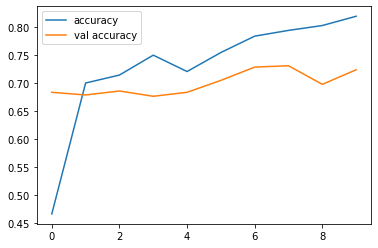

In [88]:
plt.plot(h.history['accuracy'], label='accuracy')
plt.plot(h.history['val_accuracy'], label='val accuracy')
plt.legend();

This plot shows the dramatic increase in model accuracy in the first epoch followed by a slower but fairly consistent increase in accuracy as the epochs progress. Validation accuracy hovers around 67% but increases to a peak of about 73% around epoch 6

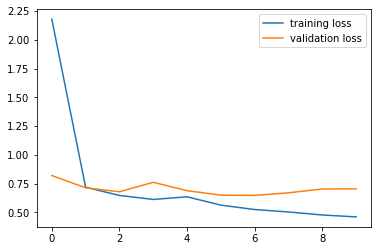

In [89]:
plt.plot(h.history['loss'], label='training loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend();

This plot shows the sharp drop in training loss at epoch one followed by additional training loss at almost every subsequent epoch. The validation loss stays relatively consistent at about .75, but starts to worsen and diverge from the training loss trend around epoch 6

### Generating Predictions

In [90]:
# generate predictions from X_test
preds = model.predict(X_test)

In [91]:
# change the list of prediction probabilities into predictions of a number 0-4 by taking the index of the max probability
simple_preds = []
for prediction in preds:
    simple_preds.append(np.where(prediction == prediction.max())[0][0])

In [92]:
# reverse-one-hot-encode y_test 

# learned about np.argmax here:
# https://stackoverflow.com/questions/54143458/convert-categorical-data-back-to-numbers-using-keras-utils-to-categorical

y_test_simple = np.argmax(y_test, axis=-1)

# make sure it worked
y_test_simple

array([3, 2, 2, 3, 1, 0, 1, 2, 3, 3, 2, 3, 1, 0, 2, 3, 3, 1, 3, 1, 1, 3,
       1, 1, 1, 1, 2, 1, 3, 0, 3, 3, 3, 1, 2, 3, 0, 2, 2, 1, 1, 2, 2, 1,
       2, 0, 2, 3, 0, 1, 3, 2, 1, 3, 0, 1, 2, 1, 3, 3, 2, 1, 2, 3, 1, 1,
       1, 3, 1, 2, 3, 2, 2, 1, 0, 0, 2, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 1,
       3, 1, 3, 0, 1, 3, 0, 1, 3, 3, 1, 2, 1, 0, 3, 3, 3, 3, 0, 2, 2, 3,
       0, 3, 0, 3, 0, 2, 1, 1, 2, 3, 0, 3, 3, 1, 0, 1, 2, 1, 0, 2, 3, 1,
       0, 1, 3, 2, 3, 0, 2, 1, 3, 1, 2, 0, 3, 2, 2, 2, 2, 1, 1, 1, 2, 3,
       0, 1, 1, 1, 0, 3, 2, 0, 1, 1, 1, 1, 1, 3, 0, 2, 1, 3, 1, 1, 3, 0,
       1, 3, 0, 1, 2, 2, 3, 3, 1, 0, 3, 1, 2, 3, 3, 3, 3, 3, 3, 0, 0, 2,
       1, 3, 0, 3, 3, 1, 0, 3, 2, 0, 3, 0, 3, 0, 2, 2, 3, 1, 0, 1, 0, 2,
       3, 3, 1, 2, 2, 3, 1, 0, 2, 3, 0, 1, 3, 3, 2, 1, 2, 2, 3, 2, 3, 3,
       0, 3, 1, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 0, 3, 2, 2, 2, 1, 0, 1, 3,
       3, 1, 3, 0, 2, 0, 3, 3, 0, 1, 1, 2, 1, 2, 0, 3, 3, 1, 1, 1, 2, 3,
       3, 2, 1, 2, 1, 3, 1, 3, 3, 1, 3, 2, 0, 2, 0,

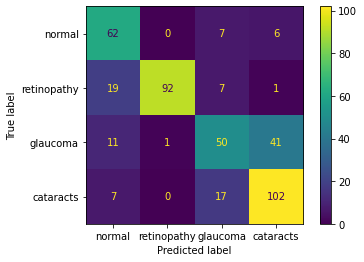

In [93]:
# make and display a confusion matrix
conf_matrix = confusion_matrix(y_test_simple, simple_preds)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=(list(condition_dict.keys()))).plot();

The model had the most difficulty distinguishing glaucoma from cataracts. The model was pretty good at identifying normal eyes. Eyes that had a condition but were classifed as normal may reflect less-severe instances of the condition.

### Feature Maps (STILL WORKING ON THIS)

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 246016)           

In [ ]:
# we don't need to do this but I found a blog about how to write code to see the feature maps generated by the model--
# https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/

# if we have time it would be cool to try this

In [66]:
layer_outputs = [layer.output for layer in model.layers]

feature_map_model = Model(inputs=model.input, outputs=layer_outputs)

In [67]:
feature_maps = feature_map_model.predict(X_test[0:3])

In [68]:
layer_names = [layer.name for layer in model.layers]

In [70]:
for layer_name, feature_map in zip(layer_names, feature_maps):  
    if len(feature_map.shape) == 4:
        k = feature_map.shape[-1]  
        size=feature_map.shape[1]
        for i in range(k):
            feature_image = feature_map[0, :, :, i]
            feature_image-= feature_image.mean()
            feature_image/= feature_image.std ()
            feature_image*=  64
            feature_image+= 128
            feature_image= np.clip(feature_image, 0, 255).astype('uint8')
            #image_belt[:, i * size : (i + 1) * size] = feature_image 

<ipython-input-70-f41ba01a6704>:8: RuntimeWarning: invalid value encountered in true_divide
  feature_image/= feature_image.std ()


In [71]:
feature_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

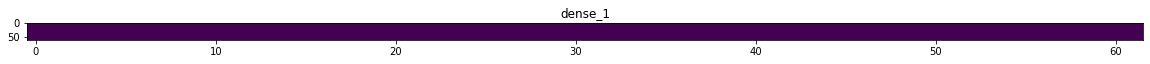

In [63]:
scale = 20. / k
plt.figure( figsize=(scale * k, scale) )
plt.title ( layer_name )
plt.grid  ( False )
plt.imshow( feature_image, aspect='auto');